# Sheet
Vergelijk de verschillen in de NBS per issue en per waarde van p

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import ipywidgets as widget
from IPython.core.display import display, HTML
from decideanalyses import settings
from decideanalyses.helpers import get_all_actors
%matplotlib inline

pd.set_option('display.max_rows', 750)
pd.set_option('display.max_columns', 500)
data_set_id = 6

In [2]:
conn = sqlite3.connect(settings.DATABASE_URL)

In [3]:
df = pd.read_sql("""
SELECT
        a.name AS actor,
        i.name as issue,
        AVG(ai.position) as postion,        
        i2.pointer                                AS iteration,
        m.p,
        m.id  
      FROM actorissue ai
        LEFT JOIN issue i ON ai.issue_id = i.id
        LEFT JOIN actor a ON ai.actor_id = a.id
        LEFT JOIN iteration i2 ON ai.iteration_id = i2.id
        LEFT JOIN repetition r ON i2.repetition_id = r.id
        LEFT JOIN modelrun m ON r.model_run_id = m.id
        LEFT JOIN dataset d ON a.data_set_id = d.id
      WHERE  ai.type = 'before' AND d.id = ?
     GROUP BY m.id, i2.pointer, a.id, i.id;
""", 
                 conn, 
                 params=(data_set_id,),
                 index_col=[ 'issue','actor','p'],                  
                 columns=['postion']
                )

table = pd.pivot_table(df, index=['issue','actor', 'iteration'], columns=['p'],values=['postion'])


# Posities 
Verloop van de positie over de verschillende onderhandelingsrondes van de actor per issue 

In [4]:
table

postion            
p                                            0.0         0.8
issue         actor        iteration                        
adapt_finance AILAC2       0          100.000000  100.000000
                           1          100.000000   91.721128
                           2           99.488934   91.721128
                           3           96.172169   88.488307
                           4           96.099094   87.073341
...                                          ...         ...
progress      Umbrella_min 5           34.971662   35.556152
                           6           41.418115   41.343994
                           7           36.818769   38.848082
                           8           36.853038   37.351196
                           9           41.823531   38.570422

[1810 rows x 2 columns]

IndexError: index 3 is out of bounds for axis 0 with size 3

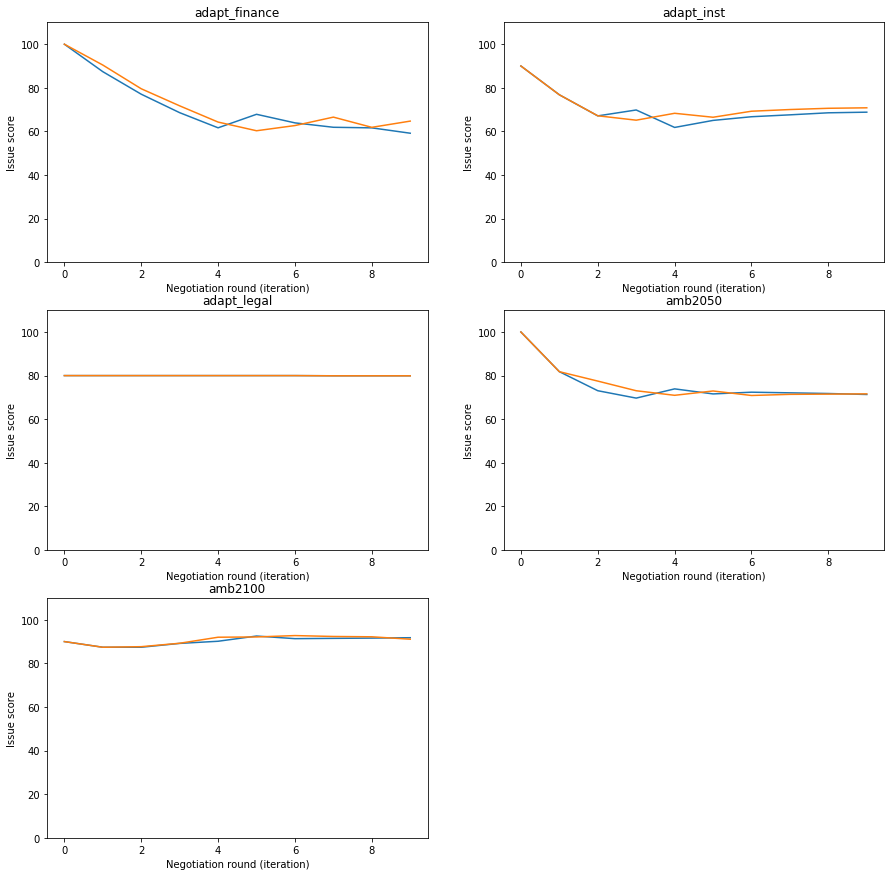

In [5]:
cursor = conn.execute('SELECT `name`, `id`, lower, upper FROM issue WHERE data_set_id = ? ORDER BY `name`', [data_set_id])
issues = cursor.fetchall()

actors = get_all_actors(conn, data_set_id=data_set_id)

for actor, actor_id in actors:
    
    fig, axes = plt.subplots(3, 2, figsize=(15,15))  # a figure with a 2x2 grid of Axes    
    i = 0
    fig.delaxes(axes[2,1])
    display(HTML('<hr><h1><center>{}</center></h1>'.format(actor)))
    for issue in issues:
        
        row = int(i / 2)
        col = i % 2
        
        subset = table.query('actor == ["{}"] and issue == ["{}"]'.format(actor, issue[0]))
        subchart = axes[row, col]
        subchart.plot(subset.values)
        subchart.set_ylim(0, 110)        
        subchart.set_title(issue[0])
        subchart.set_ylabel('Issue score')
        subchart.set_xlabel('Negotiation round (iteration)')
        
        i+=1
        
    
    plt.tight_layout()
    plt.show()
    